In [1]:
#Loading libraries
import numpy as np 
import pandas as pd 
import re 
import nltk 
import spacy 
import string 
import email
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None

import seaborn as sns
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objs as go
import plotly.figure_factory as ff

In [2]:
#Loading File
gf = pd.read_csv(r'C:\Users\Tanmayee\Downloads\emails.csv', nrows=35000)

In [3]:
# create list of email objects
emails = list(map(email.parser.Parser().parsestr,gf['message']))

# extract headings such as subject, from, to etc..
headings  = emails[0].keys()

for key in headings:
    gf[key] = [doc[key] for doc in emails]

In [4]:
# gf.head()

In [5]:
def get_raw_text(emails):
    return ''.join([email.get_payload() for email in emails.walk() if email.get_content_type() == 'text/plain'])


gf['body'] = [get_raw_text(email) for email in emails]
gf['user'] = [file.split('/')[0] for file in gf['file']]

In [6]:
gf['Date'] = pd.to_datetime(gf['Date'])
gf.head()
gf.dtypes

file                         object
message                      object
Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
body                         object
user                         object
dtype: object

In [7]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        exclusions = ['RE:', 'Re:', 're:']
        exclusions = '|'.join(exclusions)
        data = (
            data.lower()
            .replace('-', '')
            .replace('_', '')
            .replace('forwarded by phillip k allenhouect on    pm', '')
            .replace('httpitcappscorpenroncomsrrsauthemaillinkaspidpage', '')
            .replace('\'ve', ' have ')
            .replace("can't", 'cannot')
            .replace("n't", ' not')
            .replace("I'm", 'I am')
            .replace(" m ", ' am ')
            .replace("\'re", ' are ')
            .replace("\'d", ' would ')
            .replace("\'ll", ' will ')
            .replace(exclusions, '')
            .strip()
        )
        data = re.sub('\[[^]]*\]', '', data)  # Remove data between square brackets
        data = re.sub(r'[^\w\s]', '', data)  # Remove punctuation
        data = re.sub(r'\n', ' ', data)  # Replace newline characters with spaces
        data = re.sub(r'[0-9]+', '', data)  # Remove numbers
        data = re.sub(r'<.*?>', '', data)  # Strip HTML tags
        
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        
        return data.strip()
    
    return 'No Subject'

gf['Subject_new'] = gf['Subject'].apply(clean_column)
gf['body_new'] = gf['body'].apply(clean_column)

In [8]:
gf['body_new'].head(5)

0                                 here is our forecast
1    traveling to have a business meeting takes the...
2                           test successful  way to go
3    randy   can you send me a schedule of the sala...
4                            lets shoot for tuesday at
Name: body_new, dtype: object

In [9]:
gf['Subject_new'].tail(5)

34995    tms weekly mtg conference room eb
34996    tms weekly mtg conference room eb
34997    tms weekly mtg conference room eb
34998    tms weekly mtg conference room eb
34999    tms weekly mtg conference room eb
Name: Subject_new, dtype: object

In [10]:
#Shape of dataframe
print(" Shape of dataframe: ", gf['body_new'].shape)

 Shape of dataframe:  (35000,)


In [11]:
# Drop duplicates
gf.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", gf.shape)

 Shape of dataframe after dropping duplicates:  (35000, 21)


In [12]:
total = gf.shape[0]

missing_data = pd.DataFrame({
    'column name': gf.columns,
    'Total missing': gf.isnull().sum(),
    'Percent missing': gf.isnull().sum() / total
}).sort_values(by='Total missing', ascending=False).reset_index(drop=True)

print("Null Values in each column:\n", missing_data)

Null Values in each column:
                   column name  Total missing  Percent missing
0                          To           1807         0.051629
1                      X-From              5         0.000143
2                    X-Folder              5         0.000143
3                  X-FileName              5         0.000143
4                Mime-Version              5         0.000143
5                Content-Type              5         0.000143
6   Content-Transfer-Encoding              5         0.000143
7                    X-Origin              5         0.000143
8                        X-To              5         0.000143
9                        X-cc              5         0.000143
10                      X-bcc              5         0.000143
11                Subject_new              0         0.000000
12                       user              0         0.000000
13                       body              0         0.000000
14                       file            

In [13]:
!pip install vaderSentiment > nul 2>&1

In [14]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [15]:
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    print(f"{sentence:-<40} {str(score)}")

In [16]:
#testing the function
email  = "I thoroughly enjoyed witnessing the mesmerizing magic performance once more."
email2 = "I can't believe the disappointing outcome they have produced. It's absolutely dreadful!"
email3 = " I'm feeling lost and uncertain about what course of action to take."  
print (sentiment_analyzer_score(email))
print (sentiment_analyzer_score(email2))
print (sentiment_analyzer_score(email3))

I thoroughly enjoyed witnessing the mesmerizing magic performance once more. {'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.5563}
None
I can't believe the disappointing outcome they have produced. It's absolutely dreadful! {'neg': 0.216, 'neu': 0.621, 'pos': 0.163, 'compound': -0.2161}
None
 I'm feeling lost and uncertain about what course of action to take. {'neg': 0.3, 'neu': 0.6, 'pos': 0.1, 'compound': -0.4588}
None


In [17]:
from nltk.tokenize import RegexpTokenizer

In [18]:
tokenizer = RegexpTokenizer(r'\w+')

In [19]:
words_descriptions = gf['body_new'].apply(tokenizer.tokenize)
words_descriptions.head()

0                            [here, is, our, forecast]
1    [traveling, to, have, a, business, meeting, ta...
2                      [test, successful, way, to, go]
3    [randy, can, you, send, me, a, schedule, of, t...
4                      [lets, shoot, for, tuesday, at]
Name: body_new, dtype: object

In [20]:
all_words = [word for tokens in words_descriptions for word in tokens]
description_lengths = [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(word for tokens in words_descriptions for word in tokens)))

print(f"{len(all_words)} words total, with a vocabulary size of {len(VOCAB)}")

7887018 words total, with a vocabulary size of 108051


In [21]:
# Checking most common words
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('the', 321252),
 ('to', 245100),
 ('and', 155597),
 ('of', 126453),
 ('a', 125981),
 ('in', 104555),
 ('for', 95292),
 ('you', 88574),
 ('on', 82557),
 ('i', 78047),
 ('is', 75928),
 ('that', 65636),
 ('will', 60172),
 ('this', 60145),
 ('be', 56275),
 ('have', 50341),
 ('with', 49929),
 ('we', 47355),
 ('from', 46276),
 ('are', 45183),
 ('not', 44769),
 ('at', 43029),
 ('as', 41171),
 ('your', 37455),
 ('it', 37249),
 ('by', 36076),
 ('if', 32735),
 ('or', 32353),
 ('am', 31459),
 ('enron', 30965),
 ('pm', 28842),
 ('subject', 27731),
 ('please', 24195),
 ('he', 22616),
 ('all', 21891),
 ('has', 21888),
 ('would', 21645),
 ('was', 21495),
 ('do', 20913),
 ('me', 20862),
 ('an', 20296),
 ('but', 20058),
 ('cc', 20045),
 ('can', 19262),
 ('our', 18197),
 ('any', 17283),
 ('time', 16226),
 ('email', 15967),
 ('new', 15864),
 ('up', 15218),
 ('they', 14927),
 ('know', 14803),
 ('week', 14509),
 ('my', 14196),
 ('so', 14185),
 ('about', 14058),
 ('more', 13921),
 ('out', 13818),
 ('been'

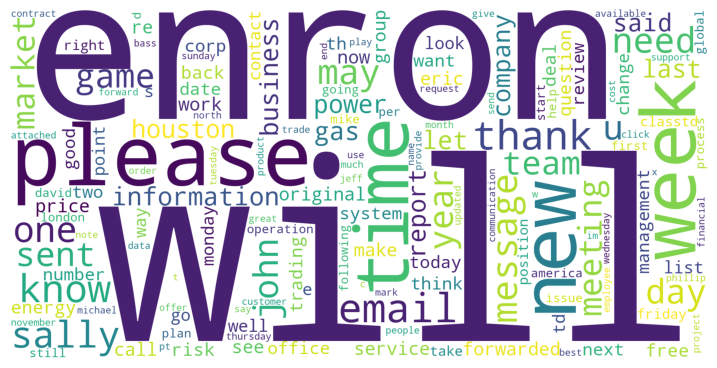

In [22]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

#Visualise Email Subject

wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(gf['body_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
gf['scores'] = gf['body_new'].apply(lambda review: analyser.polarity_scores(review))

In [24]:
gf['compound']  = gf['scores'].apply(lambda score_dict: score_dict['compound'])

In [25]:
gf['Sentiment'] = gf['compound'].apply(lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral')

In [26]:
# Grouping and aggregating the data
var1 = gf['body_new'].groupby(gf['Sentiment']).count().reset_index().sort_values(by='body_new', ascending=False)

# Creating the figure object
fig = go.Figure()

# Adding the Funnel area trace
fig.add_trace(
    go.Funnelarea(
        text=var1['Sentiment'],
        values=var1['body_new'],
        title="Funnel-Chart of Sentiment Distribution",
        textposition="inside",
        marker=dict(colors=["#636EFA", "#EF553B", "#00CC96"], line=dict(color='#000000', width=1))
    )
)

# Displaying the figure
fig.show()

In [27]:
gf['temp_list'] = gf['body_new'].apply(lambda x:str(x).split())
top = Counter([item for sublist in gf['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

In [28]:
# Splitting the words in 'body_new' column and creating a list
temp_list = gf['body_new'].str.split().tolist()

# Counting the occurrences of each word
top = Counter([item for sublist in temp_list for item in sublist])

# Creating a DataFrame with the most common words and their counts
temp = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])

In [29]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

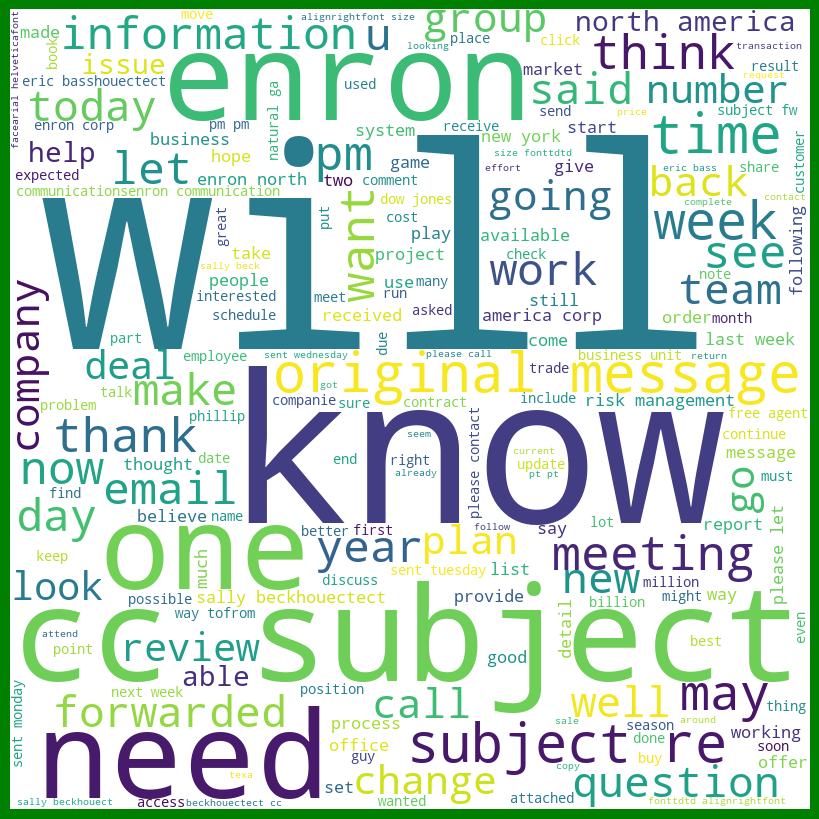

In [30]:
stopwords = set(STOPWORDS)

gf_positive = gf[gf["Sentiment"] == "Positive"]
comment_words = ' '.join(gf_positive.body_new.astype(str).str.lower())

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords, 
                      min_font_size=10).generate(comment_words)

plt.figure(figsize=(8, 8), facecolor="green")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

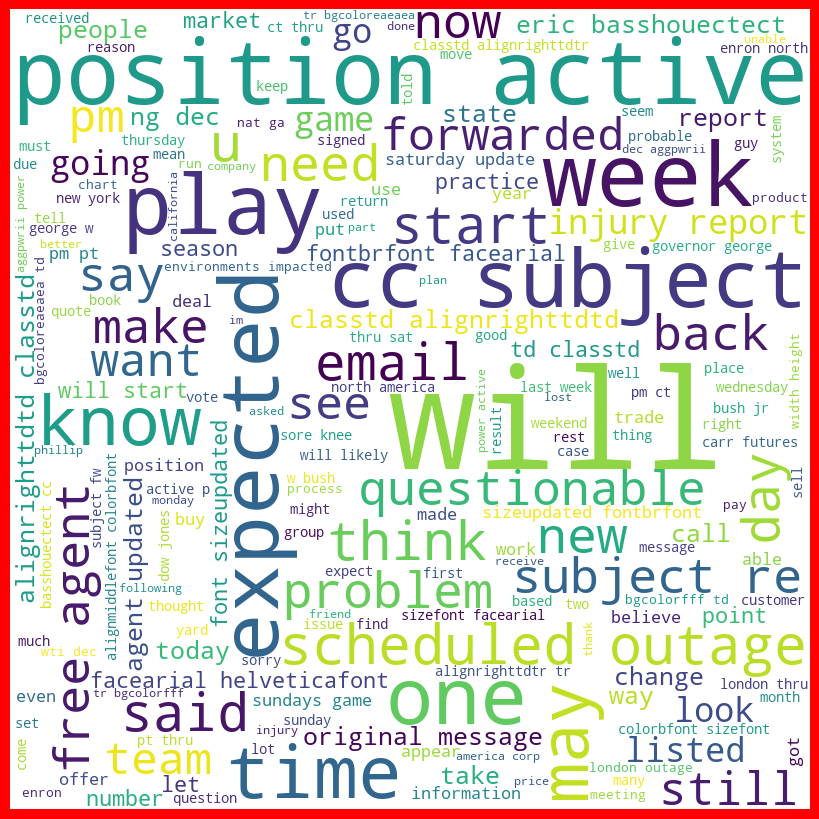

In [31]:
stopwords = set(STOPWORDS)

gf_negative = gf[gf["Sentiment"] == "Negative"]
comment_words = ' '.join(gf_negative.body_new.astype(str).str.lower())

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords, 
                      min_font_size=10).generate(comment_words)

plt.figure(figsize=(8, 8), facecolor="red")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [32]:
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob, Word, Blobber

In [33]:
email = "I would love to meet you again"
TextBlob(email).sentiment 

Sentiment(polarity=0.5, subjectivity=0.6)

In [34]:
# Applying on dataset
gf['TB_score']= gf.body_new.apply(lambda x: TextBlob(x).sentiment)

In [35]:
gf['TB_sentiment'] = gf['body_new'].apply(lambda x: TextBlob(x).sentiment[0])
gf.head()

file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                      Message-ID                       Date  \
0  <18782981.1075855378110.JavaMail.evans@thyme>  2001-05-14 16:39:00-07:00   
1  <15464986.1075855378456.JavaMail.evans@thyme>  2001-05-04 13:51:00-07:00   
2  <24216240.1075855687451.JavaMail.evans@thyme>  2000-10-18 03:00:00-07:00   
3  <13505866.1075863688222.JavaMail.evans@thyme>  2000-10-23 06:13:00-07:00   
4  <30922949.1075863688243.JavaMail.evans@thyme>  2000-08-31 05:07:00-07:00   

                      From                       To    Subject Mime-Version  \
0  phillip.allen@enron.com     tim.belden@enron.com                     1.0   
1  phillip.allen@enron.com  john.lavorato@enron.com        Re:          1.0   
2  phillip.allen@enron.com   leah.arsdall@enron.com   Re: test          1.0   
3  phillip.allen@enron.com    randall.gay@enron.com                     1.0   
4  phillip.allen@enron.com     greg.piper@enron.com  Re: Hello          1.0   

                   Content-Type Content-Transfer-Encoding  ...  \
0  text/plain; charset=us-ascii                      7bit  ...   
1  text/plain; charset=us-ascii                      7bit  ...   
2  text/plain; charset=us-ascii                      7bit  ...   
3  text/plain; charset=us-ascii                      7bit  ...   
4  text/plain; charset=us-ascii                      7bit  ...   

                                                body     user Subject_new  \
0                          Here is our forecast\n\n   allen-p               
1  Traveling to have a business meeting takes the...  allen-p          re   
2                     test successful.  way to go!!!  allen-p     re test   
3  Randy,\n\n Can you send me a schedule of the s...  allen-p               
4                Let's shoot for Tuesday at 11:45.    allen-p    re hello   

                                            body_new  \
0                               here is our forecast   
1  traveling to have a business meeting takes the...   
2                         test successful  way to go   
3  randy   can you send me a schedule of the sala...   
4                          lets shoot for tuesday at   

                                              scores compound Sentiment  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   0.0000   Neutral   
1  {'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...   0.9313  Positive   
2  {'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...   0.5859  Positive   
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   0.0000   Neutral   
4  {'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...  -0.3400  Negative   

                                           temp_list  \
0                          [here, is, our, forecast]   
1  [traveling, to, have, a, business, meeting, ta...   
2                    [test, successful, way, to, go]   
3  [randy, can, you, send, me, a, schedule, of, t...   
4                    [lets, shoot, for, tuesday, at]   

                                   TB_score TB_sentiment  
0                                (0.0, 0.0)     0.000000  
1  (0.18181818181818182, 0.603030303030303)     0.181818  
2                              (0.75, 0.95)     0.750000  
3                                (0.0, 0.0)     0.000000  
4                                (0.0, 0.0)     0.000000  

[5 rows x 27 columns]

In [36]:
!pip install NRCLex > nul 2>&1

In [37]:
from nrclex import NRCLex
email_text = 'Good work to the team'

email = NRCLex(email_text)

# Return affect dictionary
affect_dict = email.affect_dict
print(affect_dict)

# Return raw emotional counts
raw_emotion_scores = email.raw_emotion_scores
print("\n", raw_emotion_scores)

# Return highest emotions
top_emotions = email.top_emotions
print("\n", top_emotions)

# Return affect frequencies
affect_frequencies = email.affect_frequencies
print("\n", affect_frequencies)

{'team': ['trust']}

 {'trust': 1}

 [('trust', 1.0)]

 {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 'trust': 1.0, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.0, 'sadness': 0.0, 'disgust': 0.0, 'joy': 0.0}


In [38]:
def emotion(x):
    text = NRCLex(x)
    if text.top_emotions[0][1] == 0.0:
        return "No emotion"
    else:
        return text.top_emotions[0][0]
gf['Emotion'] = gf['body_new'].apply(lambda x: NRCLex(x).top_emotions[0][0] if NRCLex(x).top_emotions[0][1] != 0.0 else "No emotion")

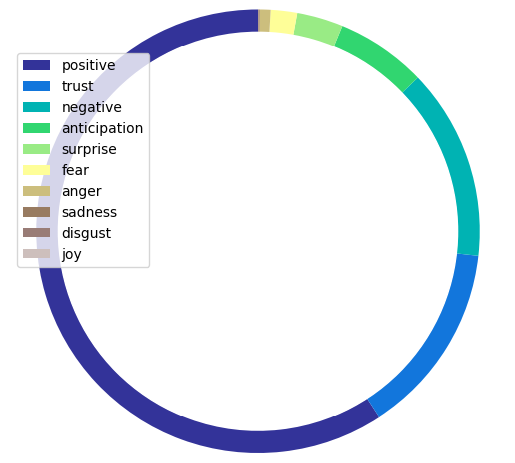

In [39]:
import matplotlib.pyplot as plt
from matplotlib import cm
from math import log10

gf_chart = gf[gf.Emotion != "No emotion"]
labels = gf_chart.Emotion.value_counts().index.tolist()
data = gf_chart.Emotion.value_counts()

# Number of data points
n = len(data)
# Find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

# Radius of donut chart
r = 1.5
# Calculate width of each ring
w = r / n

# Create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

# Create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

# Create rings of donut chart
patches, texts = ax.pie(data, radius=r, startangle=90, colors=colors, wedgeprops=dict(width=w))

# Set alpha value to make labels in segments transparent
for text in texts:
    text.set_alpha(0)

# Add inner white circle to create the donut shape
ax.add_artist(plt.Circle((0, 0), r - w, color="white"))

# Create legend
plt.legend(patches, labels, loc="best")

# Show the donut chart
plt.show()
